In [1]:
from tensorflow.keras import Sequential, Model, losses, optimizers
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense,BatchNormalization,LeakyReLU,Conv2DTranspose,Conv2D,Dropout,Flatten, Reshape

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pickle
import os
from tqdm import tqdm

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
NOISE_DIM = 100
BATCH_SIZE = 25
INSTANCE_NUM = 10000

In [4]:
def generator_model(noise_dim):
    model = Sequential()
    initializer = tf.keras.initializers.HeUniform()
    # I use Layer Normalization because my batch size is small due to small vRAM
    model.add(Dense(8*8*128, use_bias=False, input_shape=(noise_dim,), kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((8, 8, 128)))
    
    model.add(Conv2D(256, 4, strides=1, padding='same', use_bias=False, kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False, kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False, kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    # Read that removing normalization in the last couple of layers makes the output less smooth and less constraint
    model.add(Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False, activation='leaky_relu', kernel_initializer=initializer))

    model.add(Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False, activation='leaky_relu', kernel_initializer=initializer))

    model.add(Conv2D(1, 4, strides=1, padding='same', use_bias=False, activation='tanh', kernel_initializer=initializer))

    return model

generator = generator_model(NOISE_DIM)
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              819200    
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         524288    
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                        

d:\program_files\anaconda3\envs\tf_gpu\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [5]:
def discriminator_model():

    input_layer = Input(shape=[128, 128, 1])

    conv1 = Conv2D(128, 3, strides=3, padding='same')(input_layer)
    act1 = LeakyReLU()(conv1)
    drop1 = Dropout(0.3)(act1)

    conv2 = Conv2D(128, 3, strides=3, padding='same')(drop1)
    act2 = LeakyReLU()(conv2)
    drop2 = Dropout(0.3)(act2)


    conv3 = Conv2D(256, 3, strides=3, padding='same')(drop2)
    act3 = LeakyReLU()(conv3)
    drop3 = Dropout(0.3)(act3)


    conv4 = Conv2D(128, 3, strides=3, padding='same')(drop3)
    act4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.3)(act4)


    conv5 = Conv2D(128, 3, strides=3, padding='same')(drop4)
    act5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.3)(act5)


    flat = Flatten()(drop5)
    output = Dense(1)(flat)

    model = Model(inputs=input_layer, outputs=output)

    return model
discriminator = discriminator_model()
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 43, 43, 128)       1280      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 43, 43, 128)       0         
                                                                 
 dropout (Dropout)           (None, 43, 43, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 128)       147584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 15, 15, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 128)       0     

In [6]:
with open("data.pkl", "rb") as file:
    df = pickle.load(file)[:INSTANCE_NUM]

In [7]:
dataset = tf.data.Dataset.from_tensor_slices(np.asarray(df, dtype = np.float16).reshape(-1, 128, 128,1))
del df
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [8]:
import cv2
def plot_image(image,epoch,batch_number):
    img = cv2.resize(np.array(image),(512,512))
    cv2.imshow(f"output_show",img)
    if batch_number == 10000//BATCH_SIZE:
        cv2.imwrite(f"model_3/{epoch}.jpg", (img * 254).astype(np.uint8))
    if cv2.waitKey(25) & 0xFF == ord('q'):
        return
    
def plot_losses(epoch):
    fig, ax1 = plt.subplots(figsize=(6, 3))
    ax1.plot(gen_losses,label="generator")
    ax1.plot(dis_losses,label="discriminator")
    ax1.legend()
    ax1.set_yscale('log')
    ax1.set_ylim(.1, 3)
    ax1.set_title("Losses")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("Loss")
    ax1.set_xticks(range(0, epoch, 5)) 
    plt.show()

In [9]:
def ProgressBarBatch(batch_number,mag):
    total = INSTANCE_NUM//BATCH_SIZE
    print("Batch Progress:","\t\t",
          (u"■"*(batch_number*mag//total)),
          u"□"*((total-batch_number)*mag//total),
          "\t",
          batch_number,"/",total, sep='')
    
def ProgressBarEpoch(epoch,epochs,mag):
    print("Epoch Progress:","\t\t",
          (u"■"*(epoch*mag//epochs)),
          u"□"*((epochs-epoch)*mag//epochs),
          "\t",epoch + 1,"/",epochs)

In [10]:
loss_func = losses.BinaryCrossentropy(from_logits=True)
def gen_loss_calc(fake):
    return loss_func(tf.ones_like(fake), fake)

def dis_loss_calc(real, fake):
    real_loss = loss_func(tf.ones_like(real), real)
    fake_loss = loss_func(tf.zeros_like(fake), fake)
    total_loss = real_loss + fake_loss
    return total_loss

def classify_as_real(fake_or_real_output):
    threshold = 0.5  
    classified_as_real = tf.greater(fake_or_real_output, threshold)
    return tf.reduce_sum(tf.cast(classified_as_real, tf.int32))

gen_opt= optimizers.Adam(
    learning_rate=1e-5,
    )
dis_opt = optimizers.Adam(
    learning_rate=1e-5,
    )

gen_losses = []
dis_losses = []

In [11]:
def train_epoch(images, batch_size, noise_dim,epoch,batch_number,epochs):
    if len(images) < batch_size:
        print(f"Warning: Not enough images for a full batch. Using {len(images)} images.")
        batch_size = len(images)
    start = time.time()
    noise = tf.random.normal([batch_size, noise_dim],stddev = 0.3)


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generator(noise, training=True)

        real = discriminator(images, training=True)
        fake = discriminator(generated, training=True)

        gen_loss = gen_loss_calc(fake)
        dis_loss = dis_loss_calc(real, fake)
        
        
        gen_losses.append(gen_loss.numpy())
        dis_losses.append(dis_loss.numpy())
        
        gen_train_started = False
        if dis_loss<gen_loss*1.25 or gen_train_started==True:
            display("Generator is training")
            gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gen_opt.apply_gradients(zip(gen_gradients, generator.trainable_variables))
            gen_train_started = True
            
        dis_gradients = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
        dis_opt.apply_gradients(zip(dis_gradients, discriminator.trainable_variables))
        
        clear_output(wait=True)
        ProgressBarEpoch(epoch,epochs,20)
        ProgressBarBatch(batch_number,20)
        display(f"gen_loss: {gen_loss:.4f}")
        display(f"disc_loss: {dis_loss:.4f}")
        display(f"time: {time.time() - start:.2f}s") 
        
        if batch_number % 20 == 0:
            plot_image(generated[0],epoch,batch_number)     
        if batch_number == INSTANCE_NUM//BATCH_SIZE:
            generator.save("generator.keras")
            discriminator.save("discriminator.keras")
    

def train(dataset, epochs= 20,batch_size=32):
    start = time.time()
    for epoch_number in range(epochs):
        batch_number = 1
        for batch in dataset:
            batch_number+=1
            train_epoch(images = batch,
                        batch_size = batch_size,
                        noise_dim=NOISE_DIM,
                        epoch=epoch_number,
                        batch_number=batch_number,
                        epochs = epochs)
            display(f"Total time: {time.time() - start:.2f}s")
        pd.DataFrame({"gen":gen_losses,"dis":dis_losses}).to_csv("losses.csv")
        plot_losses(epoch_number)
        time.sleep(4)
    

Epoch Progress: 	  □□□□□□□□□□□□□□□□□□□□ 	 0.01
Batch Progress:	□□□□□□□□□□□□□□□□□□□	2/400


'gen_loss: 0.6874'

'disc_loss: 1.9236'

'time: 4.85s'

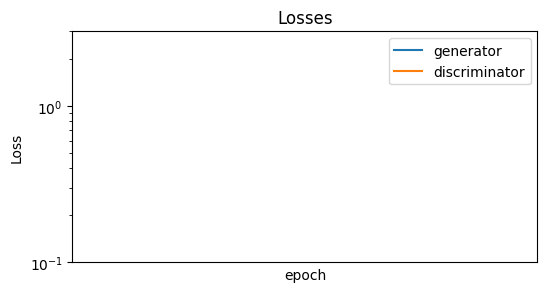

'Total time: 5.23s'

ResourceExhaustedError: {{function_node __wrapped__Conv2DBackpropInput_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[25,128,128,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropInput]

In [12]:
train(dataset, 100, BATCH_SIZE)